### Determine the optimal K number

* This notebook determines the optimal number of K based on K-means algorithm using Elbow method
* Three data processing approaches: 
* &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Approach I. 514 features were selected out of the 1063 features. See the details in separate feature selection files. All variables have been transformed into numerical values using low rank representation method, the reduced dimension matrix is used here to determine optimal K.
* &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Approach II. Drop all the categorical values and impute the numerical values with means, the method will be applied on three parallel ramdonly generated subsamples (1.25%) of the original size data.
* &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Approach III. Drop all the categorical values and impute the numerical values with means, use PCA to reduce the original 1063 dimensions. the method will be applied on three parallel ramdonly generated subsamples (1.25%) of the original size data.
* &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Approach IV 514 features were selected out of the 1063 features. Then use LASSO and PCA to contidue reduce dimension to 44 variables (all of them turned out to be numerical variables). Impute NA with means.

Reference: : https://github.com/sarguido/k-means-clustering/blob/master/k-means-clustering.ipynb

In [13]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist, pdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.decomposition import PCA
%matplotlib inline

#### Approach I. All variables have been transformed into numerical values using low rank representation method, the reduced dimension matrix is used here to determine optimal K. --This results was not completed due to memory error.

In [61]:
df = pd.read_csv('/mnt/UW/outputDataset/lowrank_rep.csv.gz')

In [23]:
df.shape

(4732698, 50)

In [8]:
df.head()

,Arch1,Arch2,Arch3,Arch4,Arch5,Arch6,Arch7,Arch8,Arch9,Arch10,...,Arch41,Arch42,Arch43,Arch44,Arch45,Arch46,Arch47,Arch48,Arch49,Arch50
0,0.023792,-0.026192,0.046124,0.057997,-0.009326,-0.001649,-0.017347,-0.026566,-0.008624,0.000035,...,0.002778,-0.008535,0.015007,0.015596,0.015161,0.002198,0.033403,-0.000672,0.000058,0.004005
1,0.015966,0.008177,-0.018576,0.056036,0.001167,-0.021675,-0.026182,0.016670,-0.004948,-0.045923,...,-0.005090,0.000951,-0.000059,-0.006419,-0.004279,0.014486,-0.000354,0.008224,-0.003906,-0.000082
2,0.023379,-0.024775,0.024896,0.046084,-0.016003,-0.015837,-0.028512,-0.031474,0.003878,0.001142,...,-0.009765,0.002476,0.024092,0.009326,0.009890,-0.014078,0.020853,-0.008587,0.006990,-0.014452
3,0.029712,-0.034318,-0.030695,0.060731,0.012181,-0.016642,0.008723,-0.017834,0.010362,0.002657,...,-0.008416,-0.000520,0.008658,0.010348,-0.006410,-0.021849,0.012883,-0.011390,0.010977,0.001848
4,0.025381,0.002224,0.003834,0.058334,-0.019646,-0.050778,-0.010127,-0.063004,-0.016856,-0.001206,...,-0.006367,-0.010286,-0.002253,-0.003586,0.006144,0.027875,0.005699,-0.006108,-0.013784,-0.007918


In [62]:
# records number is too large, use a sample to perform analysis
import random
random.seed(123)
df_sample = df.sample(frac=0.0125, replace=False)
df_sample = df_sample.fillna(df_sample.mean())
X = StandardScaler().fit_transform(df_sample)

00:04:09.06


Text(0.5,1,'Variance Explained vs. k')

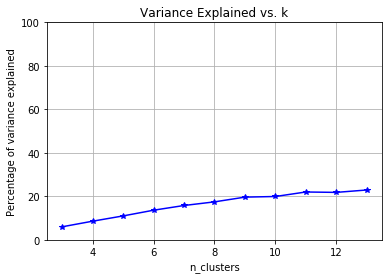

In [63]:
import time
start = time.time()
# Determine your k range
k_range = range(3,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(X) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(X)**2)/X.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')

#### Approach II. Drop all the categorical values and impute the numerical values with means, the method will be applied on three parallel ramdonly generated subsamples (1.25%) of the original size data

In [64]:
# Use a smaller data set to save time
df1 = pd.read_csv('PHBsample14_sss.csv', low_memory=False)
df2 = pd.read_csv('PHBsample15_sss.csv', low_memory=False)
df3 = pd.read_csv('PHBsample16_sss.csv', low_memory=False)

In [65]:
# drop the column resulted from sampling of the original data set
df1.drop('Unnamed: 0', axis=1, inplace=True)
df2.drop('Unnamed: 0', axis=1, inplace=True)
df3.drop('Unnamed: 0', axis=1, inplace=True)

In [66]:
selected_variable = pd.read_csv('selectedVariables.csv')
selected_variable.drop('Unnamed: 0', axis=1, inplace=True)
df1_1 = df1[df1.columns.intersection(selected_variable.columns)]
df2_1 = df2[df2.columns.intersection(selected_variable.columns)]
df3_1 = df3[df3.columns.intersection(selected_variable.columns)]

In [67]:
# Drop all the categoricald data for now.
df1_2 = df1_1.select_dtypes(include=['float64', 'int64'])
# Impute missing values with means
df1_3 = df1_2.fillna(df1_2.mean())
# Standarize the data points
X = StandardScaler().fit_transform(df1_3)

##### Subsample 1

00:43:51.34


Text(0.5,1,'Variance Explained vs. k')

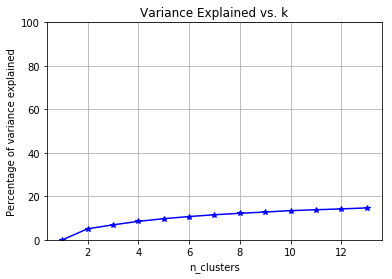

In [8]:
import time
start = time.time()
# Determine your k range
k_range = range(1,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(X) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(X)**2)/X.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')

##### Subsample 2

In [6]:
# Drop all the categoricald data for now.
df2_2 = df2_1.select_dtypes(include=['float64', 'int64'])
# Impute missing values with means
df2_3 = df2_2.fillna(df2_2.mean())
# Standarize the data points
X = StandardScaler().fit_transform(df2_3)

00:29:36.52


Text(0.5,1,'Variance Explained vs. k')

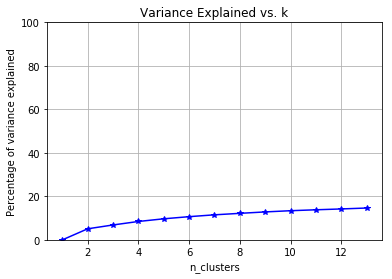

In [8]:
import time
start = time.time()
# Determine your k range
k_range = range(1,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(X) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(X)**2)/X.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')

##### Subsample 3

In [15]:
# Drop all the categoricald data for now.
df3_2 = df3_1.select_dtypes(include=['float64', 'int64'])
# Impute missing values with means
df3_3 = df3_2.fillna(df3_2.mean())
# Standarize the data points
X = StandardScaler().fit_transform(df3_3)

00:38:08.87


Text(0.5,1,'Variance Explained vs. k')

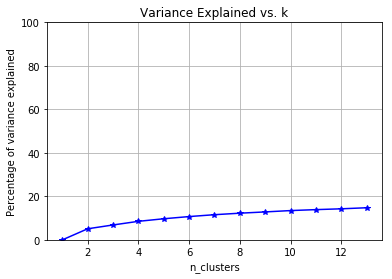

In [18]:
import time
start = time.time()
# Determine your k range
k_range = range(1,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(X) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(X)**2)/X.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')

In [8]:
fig.savefig('OptimalK_elbum.png', dpi=100)

#### Approach III. Use PCA to reduce the original 1063 dimensions. Drop all the categorical values and impute the numerical values with means, the method will be applied on a ramdonly generated subsamples (1.25%) of the original size data.

##### subsample 1

In [2]:
df = pd.read_csv('PHBsample14_sss.csv', low_memory=False)

In [3]:
# drop the column resulted from sampling of the original data set
df.drop('Unnamed: 0', axis=1, inplace=True)
# In order to run K-means, drop all the categoricald data for now.
df = df.select_dtypes(include=['float64', 'int64'])
# Impute missing values with means
df = df.fillna(df.mean())
pca = PCA(2, svd_solver='randomized')
pca.fit(df)
df_reduced = pca.fit_transform(df)
df_reduced = StandardScaler().fit_transform(df_reduced)

00:02:47.30


Text(0.5,1,'Variance Explained vs. k')

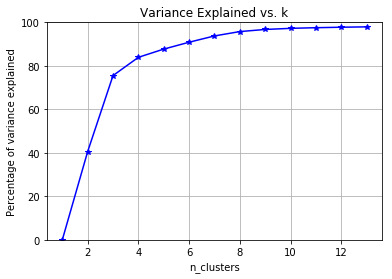

In [5]:
X = df_reduced
import time
start = time.time()
# Determine your k range
k_range = range(1,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(X) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(X)**2)/X.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')

##### subsample 2

In [6]:
df = pd.read_csv('PHBsample15_sss.csv', low_memory=False)

In [7]:
# drop the column resulted from sampling of the original data set
df.drop('Unnamed: 0', axis=1, inplace=True)
# In order to run K-means, drop all the categoricald data for now.
df = df.select_dtypes(include=['float64', 'int64'])
# Impute missing values with means
df = df.fillna(df.mean())
pca = PCA(2, svd_solver='randomized')
pca.fit(df)
df_reduced = pca.fit_transform(df)
df_reduced = StandardScaler().fit_transform(df_reduced)

00:02:35.05


Text(0.5,1,'Variance Explained vs. k')

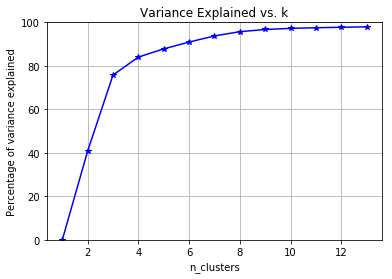

In [8]:
X = df_reduced
import time
start = time.time()
# Determine your k range
k_range = range(1,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(X) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(X)**2)/X.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')

##### subsample 3

In [9]:
df = pd.read_csv('PHBsample16_sss.csv', low_memory=False)

In [10]:
# drop the column resulted from sampling of the original data set
df.drop('Unnamed: 0', axis=1, inplace=True)
# In order to run K-means, drop all the categoricald data for now.
df = df.select_dtypes(include=['float64', 'int64'])
# Impute missing values with means
df = df.fillna(df.mean())
pca = PCA(2, svd_solver='randomized')
pca.fit(df)
df_reduced = pca.fit_transform(df)
df_reduced = StandardScaler().fit_transform(df_reduced)

00:02:41.88


Text(0.5,1,'Variance Explained vs. k')

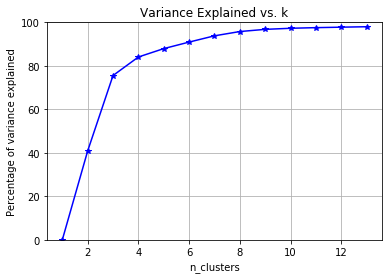

In [11]:
X = df_reduced
import time
start = time.time()
# Determine your k range
k_range = range(1,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(X) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(X)**2)/X.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')

#### Approach IV 514 features were selected out of the 1063 features. Then use LASSO and PCA to contidue reduce dimension to 44 variables (all of them turned out to be numerical variables). Impute NA with means.

In [25]:
df = pd.read_csv('/mnt/UW/outputDataset/pca_reduced_LASSO.csv')

In [48]:
# records number is too large, use a sample to perform analysis
import random
random.seed(123)
df_sample = df.sample(frac=0.0125, replace=False)

In [43]:
df_sample.shape

(118317, 44)

In [54]:
df_sample = df_sample.fillna(df_sample.mean())
X = StandardScaler().fit_transform(df_sample)

00:05:07.19


Text(0.5,1,'Variance Explained vs. k')

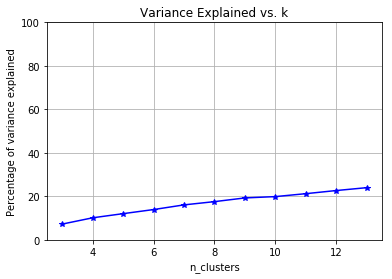

In [57]:
import time
start = time.time()
# Determine your k range
k_range = range(3,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(X) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares also known as inertia
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(X)**2)/X.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')